In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
from astropy.io import fits
import os, sys
import pickle
from tqdm import tqdm

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as phys

sys.path.append(os.environ['IH_DIR'])
from maketf.abscissa import abscs

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [20]:
def fitsfn(z, log10E, xH, xHe, nhs, base='../data/idl_output/'):
    return f'{base}tf_z_{z:.3E}_logE_{log10E:.3E}_xH_{xH:.3E}_xHe_{xHe:.3E}_nhs_{nhs:.3E}.fits'

## 1. Gas density dependence at one ($rs$, $x_{HII}$, $x_{HeII}$, $E_{in}$) point

In [19]:
# single point: low energy or high energy
z = 50 # actually 1+z
Ein = 1e5 # benchmark: 1e7 or 1e12
xH = 0.5
xHe = 0.5
nhss = np.logspace(np.log10(1e-8), np.log10(1e0), 9)
nhss = np.insert(nhss, 0, 0)
print('['+'d, '.join([f'{nhs:.10f}' for nhs in nhss])+'d]')

[0.0000000000d, 0.0000000100d, 0.0000001000d, 0.0000010000d, 0.0000100000d, 0.0001000000d, 0.0010000000d, 0.0100000000d, 0.1000000000d, 1.0000000000d]


In [21]:
hep_tfs = []
for i, nhs in enumerate(nhss):
    with fits.open(fitsfn(z, np.log10(Ein), xH, xHe, nhs)) as fitsf:
        eng = fitsf[1].data['energy'][0]
        hep_tfs.append(Spectrum(eng, fitsf[1].data['photonspectrum'][0,1]/2.0, spec_type='dNdE').N)
        #lep_tf[rs_i][Ein_i] = Spectrum(photE, fitsf[1].data['lowengphot'][0,1]/2.0, spec_type='dNdE').N
        #lee_tf[rs_i][Ein_i] = Spectrum(elecE, fitsf[1].data['lowengelec'][0,1]/2.0, spec_type='dNdE').N
        #cmbloss[rs_i][Ein_i] = fitsf[1].data['cmblosstable'][0,1]/2.0
        #hed_tf[rs_i][Ein_i] = fitsf[1].data['highdeposited_grid'][0,:,1]/2.0
        #if Ein_i == nphotE-1:
        #    lowerbound[rs_i] = fitsf[1].data['lowerbound'][0,1]
hep_tfs = np.array(hep_tfs)

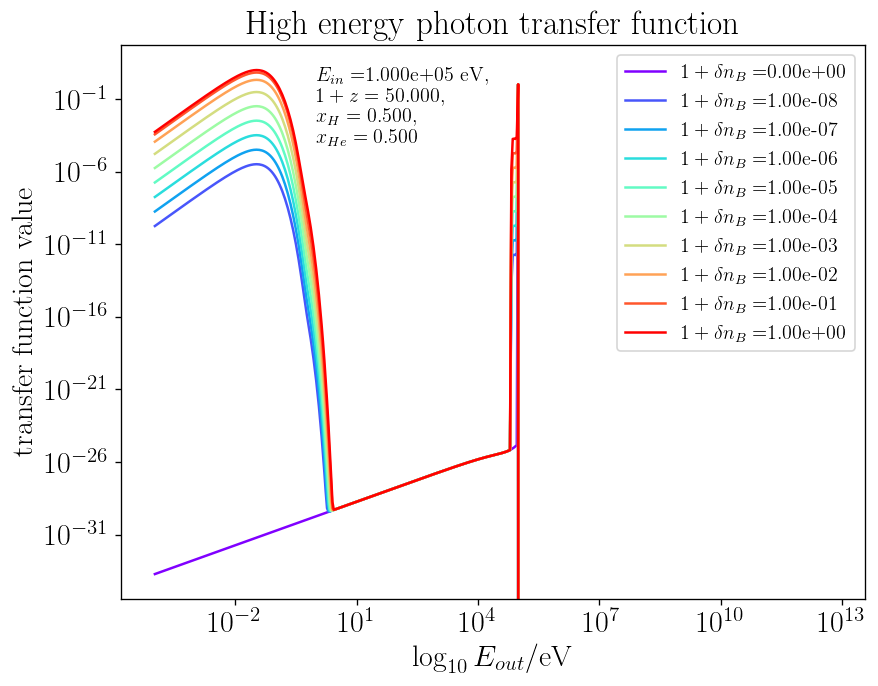

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap('rainbow')

for i, hep_tf in enumerate(hep_tfs):
    if i%1 == 0:
        ax.plot(eng, hep_tf, color=cmap(i/(len(hep_tfs)-1)), label='$1+\delta n_{B}=$%.2e'%nhss[i])
ax.set(xscale='log', yscale='log')
ax.set(title='High energy photon transfer function')
ax.set(xlabel='$\log_{10}E_{out}$/eV', ylabel='transfer function value')
ax.text(1e0, 1e-4, '$E_{in}=$%.3e eV,\n$1+z=%.3f$,\n$x_H=%.3f$,\n$x_{He}=%.3f$' % (Ein, z, xH, xHe), fontsize=12)
ax.legend(fontsize=12);

## 1.1 Location in transfer function

In [13]:
hep_tfinterp = pickle.load(open(os.environ['DH_DATA_DIR']+'/highengphot_tf_interp.raw', 'rb'))

In [14]:
hep_tf2d = hep_tfinterp.get_tf(xH, xHe*(phys.YHe/(4*(1-phys.YHe))), 1000)

In [15]:
def plot_val(x):
    return np.flipud(np.log10(np.clip(np.abs(x), 1e-100, None)))

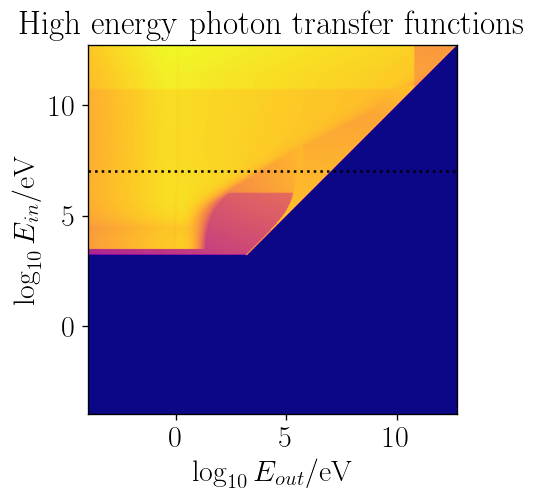

In [19]:
plt.imshow(plot_val(hep_tf2d.grid_vals), vmin=-55, cmap='plasma',
           extent=np.log10((hep_tf2d.eng[0], hep_tf2d.eng[-1], hep_tf2d.eng[0], hep_tf2d.eng[-1])))
plt.title('High energy photon transfer functions')
plt.xlabel('$\log_{10}E_{out}$/eV')
plt.ylabel('$\log_{10}E_{in}$/eV');
plt.axhline(y=np.log10(Ein), color='k', linestyle=':');

## 2. How linear is the typical gas density dependence?

### 2.1 single point

In [30]:
rvals = []
for tf_nhd in hep_tfs.transpose():
    if tf_nhd[5] > 0:
        fit_y = tf_nhd[1:]
        fit_x = (nhds+1)[1:]
        k, b, r, p, std_err = stats.linregress(fit_x, fit_y)
        rvals.append(r)
    else:
        rvals.append(np.inf)
rvals = np.array(rvals)
print('# of valid values', np.sum(rvals < np.inf))

# of valid values 478


<ipython-input-34-f150dd992ae1>:6: RuntimeWarning: invalid value encountered in true_divide
  plotvs /= plotvs[-1]
<ipython-input-34-f150dd992ae1>:12: RuntimeWarning: divide by zero encountered in log10
  plotvs = np.log10(hep_tfs)
<ipython-input-34-f150dd992ae1>:13: RuntimeWarning: invalid value encountered in subtract
  plotvs -= plotvs[0]


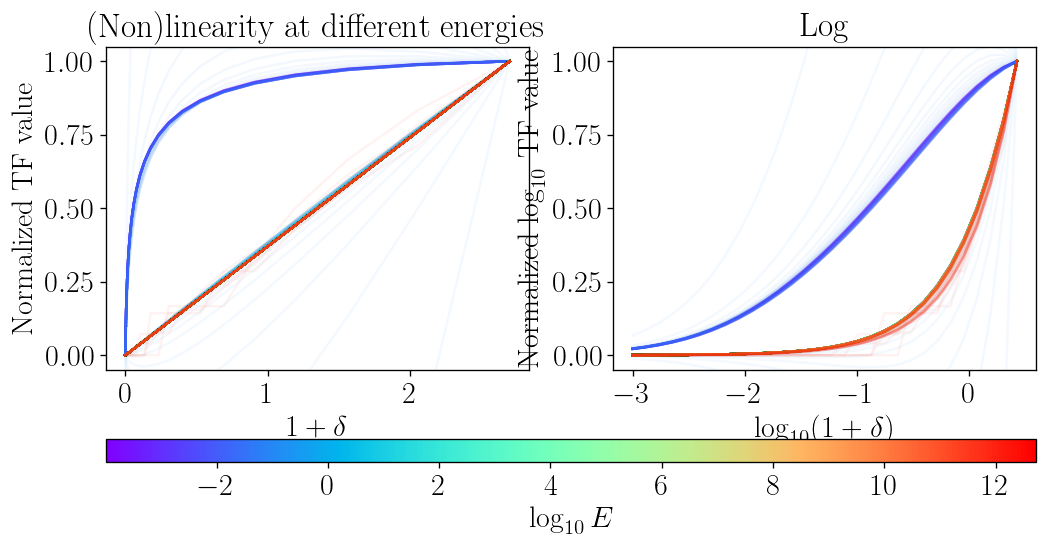

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
cmap = plt.get_cmap('rainbow')

plotvs = hep_tfs.copy()
plotvs -= plotvs[0]
plotvs /= plotvs[-1]
for i, plotv in enumerate(np.transpose(plotvs)):
    im = axs[0].plot(nhds+1, plotv, color=cmap(i/500), alpha=0.05)
axs[0].set(title='(Non)linearity at different energies', xlabel='$1+\delta$', ylabel='Normalized TF value')
axs[0].set(ylim=(-0.05, 1.05))

plotvs = np.log10(hep_tfs)
plotvs -= plotvs[0]
plotvs /= plotvs[-1]
for i, plotv in enumerate(np.transpose(plotvs)):
    axs[1].plot(np.log10((nhds+1)[1:]), plotv[1:], color=cmap(i/500), alpha=0.05)
axs[1].set(ylim=(-0.05, 1.05))
axs[1].set(title='Log', xlabel='$\log_{10}(1+\delta)$', ylabel='Normalized $\log_{10}$ TF value')

norm = mpl.colors.Normalize(vmin=np.log10(abscs['photeng'][0]),
                            vmax=np.log10(abscs['photeng'][499]))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='horizontal',
             label='$\log_{10}E$', aspect=40);

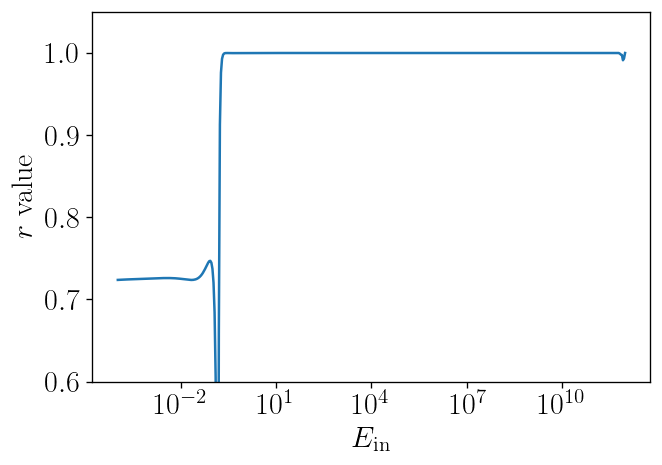

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(abscs['photeng'][rvals<np.inf], np.abs(rvals[rvals<np.inf]))
ax.set(xscale='log')
ax.set(ylim=(0.6,1.05))
ax.set(xlabel='$E_\mathrm{in}$', ylabel='$r$ value');

### 2.2 scan

In [81]:
zs   = np.logspace(np.log10(4), np.log10(50), 7) # actually 1+z
Eins = np.logspace(2, 12.7, 7)
xs   = np.array([0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99])
nhds = np.logspace(np.log10(0.001), np.log10(2.7), 7) - 1

In [82]:
for arr in [zs, Eins, xs, nhds]:
    print('['+'d, '.join([f'{a:.10f}' for a in arr])+'d]')

[4.0000000000d, 6.0936615158d, 9.2831776672d, 14.1421356237d, 21.5443469003d, 32.8209893973d, 50.0000000000d]
[100.0000000000d, 6072.0219569099d, 368694.5064519573d, 22387211.3856833763d, 1359356390.8785240650d, 82540418526.8017272949d, 5011872336272.7148437500d]
[0.0100000000d, 0.1000000000d, 0.2000000000d, 0.5000000000d, 0.8000000000d, 0.9000000000d, 0.9900000000d]
[-0.9990000000d, -0.9962684097d, -0.9860752335d, -0.9480384758d, -0.8061008779d, -0.2764479081d, 1.7000000000d]


In [83]:
rvals = []
c = 0
for z in zs:
    for Ein in Eins:
        for x in xs:
            c += 1
            print(f'\r{c}/343', flush=True, end='')
            hep_tfs = []
            for i, nhd in enumerate(nhds):
                with fits.open(fitsfn(z, np.log10(Ein), x, x, nhd)) as fitsf:
                    eng = fitsf[1].data['energy'][0]
                    hep_tfs.append(Spectrum(eng, fitsf[1].data['photonspectrum'][0,1]/2.0, spec_type='dNdE').N)
                    #lep_tf[rs_i][Ein_i] = Spectrum(photE, fitsf[1].data['lowengphot'][0,1]/2.0, spec_type='dNdE').N
                    #lee_tf[rs_i][Ein_i] = Spectrum(elecE, fitsf[1].data['lowengelec'][0,1]/2.0, spec_type='dNdE').N
                    #cmbloss[rs_i][Ein_i] = fitsf[1].data['cmblosstable'][0,1]/2.0
                    #hed_tf[rs_i][Ein_i] = fitsf[1].data['highdeposited_grid'][0,:,1]/2.0
                    #if Ein_i == nphotE-1:
                    #    lowerbound[rs_i] = fitsf[1].data['lowerbound'][0,1]
            hep_tfs = np.array(hep_tfs)
            for tf_nhd in np.log(hep_tfs.transpose()):
                if tf_nhd[5] > -100:
                    fit_vals = tf_nhd[1:]
                    k, b, r, p, std_err = stats.linregress(range(len(fit_vals)), fit_vals)
                    rvals.append(r)

2/343

<ipython-input-83-6917e4ef3742>:20: RuntimeWarning: divide by zero encountered in log
  for tf_nhd in np.log(hep_tfs.transpose()):


343/343

## 3. Test abscs

In [4]:
abscs_nhd = {
    'nhd' : np.linspace(-1., 1.7, 5),
    'x' : np.linspace(1e-5, 1-1e-5, 5),
    'rs' : np.logspace(np.log10(5.), np.log10(50.), 5),
    'eng' : abscs['photeng']
}

for key, item in abscs_nhd.items():
    if key != 'eng':
        print(key+' = ['+'d, '.join([f'{v:.10f}' for v in item])+'d]')

nhd = [-1.0000000000d, -0.3250000000d, 0.3500000000d, 1.0250000000d, 1.7000000000d]
x = [0.0000100000d, 0.2500050000d, 0.5000000000d, 0.7499950000d, 0.9999900000d]
rs = [5.0000000000d, 8.8913970502d, 15.8113883008d, 28.1170662595d, 50.0000000000d]
